In [145]:
# Fall 2025 Term Project
# Ece Melisa Kocak

In [146]:
# importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mlxtend.plotting import heatmap
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [147]:
# 2 datasets --> first one is for passing statistics and second one is for contracts, both are necesary to tie together my two reserach questions.

# Passing Statistics
data = pd.read_csv("NFL QB Stats.csv")
print("Data 1 shape:", data.shape)
# Using year between 2000 and 2022, increased the year for more data!
data = data[(data["Year"] >= 2000) & (data["Year"] <= 2022)]

# Contract statistics
data2 = pd.read_csv("combined_data_2000-2023.csv")
print("Data 2 shape:", data2.shape)
data2 = data2[data2["pos"] == "QB"] # only focusing on quarterbacks
data2 = data2[(data2["draft_year"] >= 2000) & (data2["draft_year"] <= 2022)]

# Cleaning
data2 = data2.drop(columns = ["pos", "id", "value", "gtd", "search_key"])
data2 = data2.rename(columns = {"draft_year" :"Draft_Year" , "rnd" : "Draft_Round" , "g": "Games", "pick": "Draft_Pick", "tm": "Draft_Team", "player" :"Player", "year_signed": "Year_Signed",
"signing_tm": "Signing_Team", "value_norm": "Normalized_Contract_Value", "gtd_norm": "Normalized_Guaranteed_Value"})
# Changing the floats so it looks nicer!
int_cols = ["Draft_Pick", "Draft_Round", "Games", "Year_Signed"]
for c in int_cols:
  data2[c] = data2[c].astype("Int64")

Data 1 shape: (3177, 17)
Data 2 shape: (12629, 15)


In [148]:
data.head()

,Year,Player,Pass Yds,Yds/Att,Att,Cmp,Cmp %,TD,INT,Rate,1st,1st%,20+,40+,Lng,Sck,SckY
0,2022,Patrick Mahomes,5250,8.1,648,435,67.1,41,12,105.2,272,42.0,73,13,67,26,188
1,2022,Justin Herbert,4739,6.8,699,477,68.2,25,10,93.2,228,32.6,50,7,55,38,206
2,2022,Tom Brady,4694,6.4,733,490,66.8,25,9,90.7,237,32.3,50,8,63,22,160
3,2022,Kirk Cousins,4547,7.1,643,424,65.9,29,14,92.5,230,35.8,47,10,66,46,329
4,2022,Joe Burrow,4475,7.4,606,414,68.3,35,12,100.8,219,36.1,53,10,60,41,259


In [149]:
data2.head()

,Draft_Year,Draft_Round,Draft_Pick,Draft_Team,Player,Games,Year_Signed,Signing_Team,Normalized_Contract_Value,Normalized_Guaranteed_Value
11,2000,1,18,NYJ,Chad Pennington,89,2004,Jets,0.796679,0.223375
12,2000,1,18,NYJ,Chad Pennington,89,2010,Dolphins,0.047252,0.020544
13,2000,1,18,NYJ,Chad Pennington,89,2008,Dolphins,0.068966,0.030172
14,2000,1,18,NYJ,Chad Pennington,89,2000,Jets,0.092566,0.066445
19,2000,6,199,NWE,Tom Brady,335,2005,Patriots,0.561404,0.309942


In [150]:
# Need to rename teams, for them to match signing team and draft team format
teams = {"Browns": "CLE", "Bengals": "CIN","Steelers": "PIT","Ravens": "BAL", "NWE": "NE", "Patriots": "NE", "Bills": "BUF", "Jets": "NYJ","Dolphins": "MIA",
  "Texans": "HOU", "Colts": "IND", "Jaguars": "JAX", "Titans": "TEN", "Broncos": "DEN", "KAN": "KC", "Chiefs": "KC","SDG": "LAC", "Chargers": "LAC",
  "OAK": "LV", "LVR": "LV", "Raiders": "LV", "Vikings": "MIN", "Lions": "DET", "Bears": "CHI","GNB": "GB", "Packers": "GB","Falcons": "ATL", "Panthers": "CAR",
  "TAM": "TB", "Buccaneers": "TB","NOR": "NO", "Saints": "NO", "Cowboys": "DAL","Giants": "NYG","Eagles": "PHI", "Washington": "WAS","Commanders": "WAS",
  "Seahawks": "SEA","Cardinals": "ARI","STL": "LAR", "Rams": "LAR", "49ers": "SF", "SFO": "SF"}

# Using a helper function to check the teams
def teams_helper(team):
  if pd.isna(team):
    return None
  team = str(team).strip()
  # some teams are labeled differently
  if "/" in team:
    team = team.split("/")[0]
    #taking the first team
  return teams.get(team, team)

In [151]:
# Fixing the teams in both columns
data2["Draft_Team"] = data2["Draft_Team"].apply(teams_helper)
data2["Signing_Team"] = data2["Signing_Team"].apply(teams_helper)

# Rookie teams
rookie = data2.groupby("Player")["Draft_Team"].first().reset_index()
# Draft team should not change^

# Creating a df for both
# Second contract teams -- first non rookie
second = (data2[data2["Year_Signed"] > data2["Draft_Year"]].sort_values(["Player", "Year_Signed"]).groupby("Player").first().reset_index()[["Player","Signing_Team","Year_Signed"]])
contract_info = rookie.merge(second, on = "Player", how = "left")
# contract_info = contract_info.dropna(subset=["Signing_Team"])
contract_info

,Player,Draft_Team,Signing_Team,Year_Signed
0,A.J. McCarron,CIN,LV,2018
1,Aaron Rodgers,GB,GB,2008
2,Alex Smith,SF,SF,2009
3,Andrew Luck,IND,IND,2016
4,Andy Dalton,CIN,CIN,2014
...,...,...,...,...
143,Tua Tagovailoa,MIA,NaN,<NA>
144,Tyrod Taylor,BAL,BUF,2015
145,Will Grier,CAR,DAL,2022
146,Zach Mettenberger,TEN,NaN,<NA>


In [152]:
# Lets make a helper for identifying the type of contracts --> retained, transfered, no contract
def contract_type_helper(row):
  if pd.isna(row["Signing_Team"]):
    # NaN case
    return "No Contract"
  elif row["Signing_Team"] == row["Draft_Team"]:
    # stayed with the team
    return "Retained"
  else:
    return "Transferred"

# New column for three different contract types
contract_info["Contract_Type"] = contract_info.apply(contract_type_helper, axis = 1)
contract_info

,Player,Draft_Team,Signing_Team,Year_Signed,Contract_Type
0,A.J. McCarron,CIN,LV,2018,Transferred
1,Aaron Rodgers,GB,GB,2008,Retained
2,Alex Smith,SF,SF,2009,Retained
3,Andrew Luck,IND,IND,2016,Retained
4,Andy Dalton,CIN,CIN,2014,Retained
...,...,...,...,...,...
143,Tua Tagovailoa,MIA,NaN,<NA>,No Contract
144,Tyrod Taylor,BAL,BUF,2015,Transferred
145,Will Grier,CAR,DAL,2022,Transferred
146,Zach Mettenberger,TEN,NaN,<NA>,No Contract


In [153]:
# Identifying the eligible quarterbacks (the ones that played at least 4 seasons)
years_played = (data.groupby("Player")["Year"].nunique().reset_index(name = "Seasons"))
eligible_players = years_played[years_played["Seasons"] >= 4]["Player"]
qb_data = data[data["Player"].isin(eligible_players)].sort_values(["Player", "Year"])
# Keeping the stats of eligible qb

first4 = qb_data.groupby("Player").head(4)
# Looking only on first four
# Building the passing stat and cleaning!
# Rate averaged accross season
features = first4.groupby("Player").agg({"Pass Yds": "sum", "TD": "sum","INT": "sum","Att": "sum","Cmp": "sum", "Rate": "mean"}).reset_index()
features = features.rename(columns={"Pass Yds": "Passing_Yards", "TD": "Touchdowns", "INT": "Interceptions", "Att": "Attempts", "Cmp": "Completions"})
# dropped this earlier, adding it manual
features["Completion_Percentage"] = (features["Completions"] / features["Attempts"]) * 100
features.head()

,Player,Passing_Yards,Touchdowns,Interceptions,Attempts,Completions,Rate,Completion_Percentage
0,A.J. Feeley,3389,22,21,562,313,93.500,55.693950
1,Aaron Brooks,12464,86,51,1798,1014,82.775,56.395996
2,Aaron Rodgers,12612,87,31,1580,1023,101.050,64.746835
3,Alex Smith,7029,37,43,1172,660,63.575,56.313993
4,Andrew Luck,14838,101,55,2106,1224,83.725,58.119658


In [154]:
# So far, I have cleaned data, added contract types and filtered the qbs based on my criteria
# Now, I will add each feature's z score, as well as define the qbs performance in groups based on the z scores.
# The nan's in signing team are useful for now, so did not remove them!

# passing yards
p_mean = features["Passing_Yards"].mean()
p_std = features["Passing_Yards"].std()
# touchdowns
t_mean = features["Touchdowns"].mean()
t_std = features["Touchdowns"].std()
# interceptions
i_mean = features["Interceptions"].mean()
i_std = features["Interceptions"].std()
# attempts
a_mean = features["Attempts"].mean()
a_std = features["Attempts"].std()
# completions
c_mean = features["Completions"].mean()
c_std = features["Completions"].std()
# rate
r_mean = features["Rate"].mean()
r_std = features["Rate"].std()
# completions_percentage
cp_mean = features["Completion_Percentage"].mean()
cp_std = features["Completion_Percentage"].std()

# z scores
features["Passing_Yards_Z"] = (features["Passing_Yards"] - p_mean) / p_std
features["Touchdown_Z"] = (features["Touchdowns"] - t_mean) / t_std
features["Interceptions_Z"] = (i_mean - features["Interceptions"]) / i_std
# flipping the interceptions formula because lower interceptions are better!
features["Attempts_Z"] = (features["Attempts"] - a_mean) / a_std
features["Completion_Z"] = (features["Completions"] - c_mean) / c_std
features["Completion_Percentage_Z"] = (features["Completion_Percentage"] - cp_mean) / cp_std
features["Rate_Z"] = (features["Rate"] - r_mean) / r_std

# helper to define if qbs are underperforming, average or elite
def sd_helper(z):
  if z < -1:
    return "Underperforming"
  elif z > 1:
    return "Elite"
  else:
    return "Average"

# adding findings into new column
features["Passing_Yards_Group"] = features["Passing_Yards_Z"].apply(sd_helper)
features["Touchdown_Group"] = features["Touchdown_Z"].apply(sd_helper)
features["Interceptions_Group"] = features["Interceptions_Z"].apply(sd_helper)
features["Attempts_Group"] = features["Attempts_Z"].apply(sd_helper)
features["Completion_Group"] = features["Completion_Z"].apply(sd_helper)
features["Completion_Percentage_Group"] = features["Completion_Percentage_Z"].apply(sd_helper)
# Remember that passer rating is imperfect stat calculation and it is only showing the 4 years.
features["Rate_Group"] = features["Rate_Z"].apply(sd_helper)

# This is important to see and to define for how qbs do within each passing statistics
features.head()

,Player,Passing_Yards,Touchdowns,Interceptions,Attempts,Completions,Rate,Completion_Percentage,Passing_Yards_Z,Touchdown_Z,...,Completion_Z,Completion_Percentage_Z,Rate_Z,Passing_Yards_Group,Touchdown_Group,Interceptions_Group,Attempts_Group,Completion_Group,Completion_Percentage_Group,Rate_Group
0,A.J. Feeley,3389,22,21,562,313,93.500,55.693950,-1.169840,-0.956773,...,-1.140714,-1.299663,1.303665,Underperforming,Average,Average,Underperforming,Underperforming,Underperforming,Elite
1,Aaron Brooks,12464,86,51,1798,1014,82.775,56.395996,0.956234,1.182388,...,0.771793,-1.088879,0.147995,Average,Elite,Average,Elite,Average,Underperforming,Average
2,Aaron Rodgers,12612,87,31,1580,1023,101.050,64.746835,0.990907,1.215812,...,0.796347,1.418394,2.117214,Average,Elite,Average,Average,Average,Elite,Elite
3,Alex Smith,7029,37,43,1172,660,63.575,56.313993,-0.317068,-0.455407,...,-0.194009,-1.113500,-1.920898,Average,Average,Average,Average,Average,Underperforming,Underperforming
4,Andrew Luck,14838,101,55,2106,1224,83.725,58.119658,1.512410,1.683754,...,1.344727,-0.571363,0.250362,Elite,Elite,Underperforming,Elite,Elite,Average,Average


In [155]:
#Printing to see how many different performing groups in each feature
f_cols = ["Passing_Yards_Group","Touchdown_Group","Interceptions_Group","Attempts_Group","Completion_Group", "Completion_Percentage_Group", "Rate_Group"]
table =[]
for col in f_cols:
  result = (features[col].value_counts().rename(col))
  table.append(result)

# nicer format for the report!
final_table = pd.concat(table, axis=1)
final_table

,Passing_Yards_Group,Touchdown_Group,Interceptions_Group,Attempts_Group,Completion_Group,Completion_Percentage_Group,Rate_Group
Average,78,87,87,79,78,93,95
Underperforming,33,25,30,31,32,25,29
Elite,33,32,27,34,34,26,20


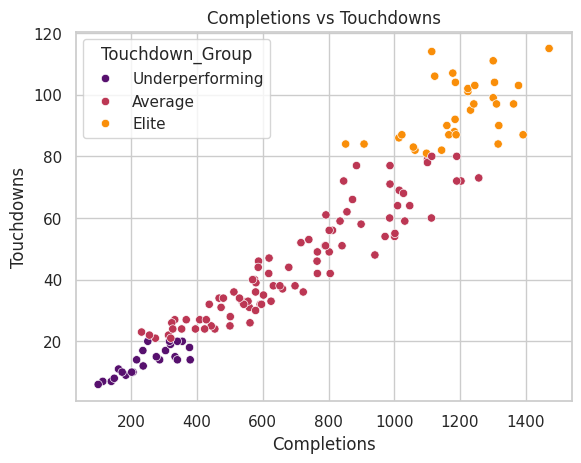

In [156]:
# Let's plot the most qb driven stats!
sns.scatterplot(data = features, x = "Completions", y = "Touchdowns",hue = "Touchdown_Group", hue_order =["Underperforming", "Average", "Elite"], palette="inferno")
plt.title("Completions vs Touchdowns")
plt.grid(True)
plt.show()

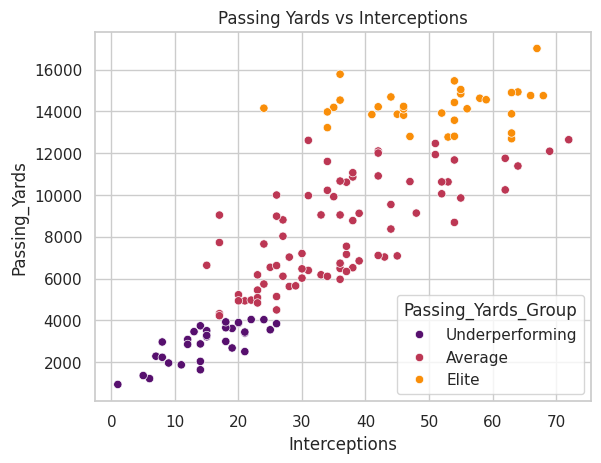

In [157]:
# Above graph is as expected. Let's test connection purely in volume
# Can be done by passing yard and interceptions
sns.scatterplot(data = features, x = "Interceptions", y = "Passing_Yards", hue = "Passing_Yards_Group", hue_order =["Underperforming", "Average", "Elite"], palette = "inferno")
plt.title("Passing Yards vs Interceptions")
plt.grid(True)
plt.show()

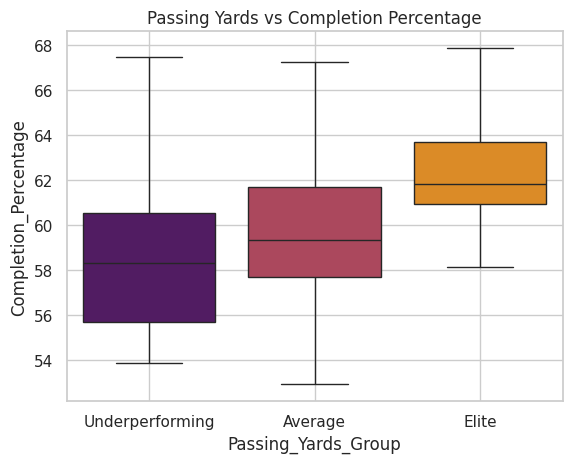

In [158]:
# Important: for above plot, the furthest to the left would be the best qb in elite cluster

# Let's do one more. This time box plot in order to show one of the filters of qb retantion is completion percentage.
# Because passing yards are a volume stat, the relationship between completion percentage and passing yards shows that only quarterbacks
# who complete a higher percentage are kept.
sns.boxplot(data = features, x = "Passing_Yards_Group", y = "Completion_Percentage", hue = "Passing_Yards_Group", order = ["Underperforming", "Average", "Elite"], palette ="inferno", legend=False)
plt.title("Passing Yards vs Completion Percentage")
plt.grid(True)
plt.show()

In [159]:
final_data = features.merge(contract_info[["Player", "Contract_Type"]], on="Player", how="left")
final_data["Player"].nunique()
# this is how many quarterbacks, i will be working with after filtering and cleaning

144

In [160]:
# If they don't appear in both csv, no contract!
final_data["Contract_Type"] = final_data["Contract_Type"].fillna("No Contract")
final_data["Second_Contract"] = final_data["Contract_Type"].apply(lambda x: 0 if x == "No Contract" else 1)
# Answering my first research question!

# the total needs to match:
print(final_data["Second_Contract"].value_counts())
print("\n")
print(final_data["Contract_Type"].value_counts())
print("\n")
final_data.groupby("Second_Contract")[["Passing_Yards","Touchdowns","Interceptions","Attempts","Completions"]].mean()
# by doing this, i am hoping to see higher numbers for qbs with second contract

Second_Contract
0    73
1    71
Name: count, dtype: int64


Contract_Type
No Contract    73
Transferred    41
Retained       30
Name: count, dtype: int64




,Passing_Yards,Touchdowns,Interceptions,Attempts,Completions
Second_Contract,,,,,
0,7163.575342,42.452055,32.410959,1045.753425,624.506849
1,9635.521127,59.028169,36.774648,1376.676056,840.718310


In [161]:
# check point for backups or qbs that should not be in final_df
dropped = set(contract_info["Player"]) - set(final_data["Player"])
dropped

{'A.J. McCarron',
 'B.J. Daniels',
 'Bailey Zappe',
 'Ben DiNucci',
 'Brandon Allen',
 'Brett Hundley',
 'Brock Purdy',
 'Bryce Petty',
 'C.J. Beathard',
 'Cardale Jones',
 'Chad Kelly',
 'Cody Kessler',
 'Connor Cook',
 'David Fales',
 'Davis Mills',
 'Davis Webb',
 'DeShone Kizer',
 'Desmond Ridder',
 'Drew Lock',
 'Dwayne Haskins',
 'Easton Stick',
 'Gardner Minshew II',
 'Garrett Gilbert',
 'Greg McElroy',
 'Ian Book',
 'JaMarcus Russell',
 'Jacob Eason',
 'Jake Fromm',
 'Jake Luton',
 'Jake Rudock',
 'Jalen Hurts',
 'Jarrett Stidham',
 'Joe Burrow',
 'Johnny Manziel',
 'Jordan Love',
 'Josh Rosen',
 'Joshua Dobbs',
 'Justin Fields',
 'Justin Herbert',
 'Kellen Mond',
 'Kenny Pickett',
 'Kevin Hogan',
 'Kyle Lauletta',
 'Kyle Trask',
 'Landry Jones',
 'Logan Thomas',
 'Logan Woodside',
 'Luke Falk',
 'Mac Jones',
 'Malik Willis',
 'Mason Rudolph',
 'Matt Flynn',
 'Michael Vick',
 'Mike White',
 'Nate Sudfeld',
 'Nathan Peterman',
 'Paxton Lynch',
 'Ryan Finley',
 'Ryan Lindley',
 '

In [162]:
final_data

,Player,Passing_Yards,Touchdowns,Interceptions,Attempts,Completions,Rate,Completion_Percentage,Passing_Yards_Z,Touchdown_Z,...,Rate_Z,Passing_Yards_Group,Touchdown_Group,Interceptions_Group,Attempts_Group,Completion_Group,Completion_Percentage_Group,Rate_Group,Contract_Type,Second_Contract
0,A.J. Feeley,3389,22,21,562,313,93.500,55.693950,-1.169840,-0.956773,...,1.303665,Underperforming,Average,Average,Underperforming,Underperforming,Underperforming,Elite,No Contract,0
1,Aaron Brooks,12464,86,51,1798,1014,82.775,56.395996,0.956234,1.182388,...,0.147995,Average,Elite,Average,Elite,Average,Underperforming,Average,No Contract,0
2,Aaron Rodgers,12612,87,31,1580,1023,101.050,64.746835,0.990907,1.215812,...,2.117214,Average,Elite,Average,Average,Average,Elite,Elite,Retained,1
3,Alex Smith,7029,37,43,1172,660,63.575,56.313993,-0.317068,-0.455407,...,-1.920898,Average,Average,Average,Average,Average,Underperforming,Underperforming,Retained,1
4,Andrew Luck,14838,101,55,2106,1224,83.725,58.119658,1.512410,1.683754,...,0.250362,Elite,Elite,Underperforming,Elite,Elite,Average,Average,Retained,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,Trent Green,13575,83,54,1756,1058,89.525,60.250569,1.216517,1.082115,...,0.875340,Elite,Elite,Underperforming,Average,Average,Average,Average,No Contract,0
140,Trevor Siemian,7024,42,28,1049,618,80.675,58.913251,-0.318239,-0.288285,...,-0.078291,Average,Average,Average,Average,Average,Average,Average,Transferred,1
141,Tyrod Taylor,9036,51,17,1265,791,85.125,62.529644,0.153128,0.012534,...,0.401218,Average,Average,Elite,Average,Average,Average,Average,Transferred,1
142,Vince Young,6843,32,39,1034,596,71.275,57.640232,-0.360643,-0.622529,...,-1.091186,Average,Average,Average,Average,Average,Average,Underperforming,No Contract,0


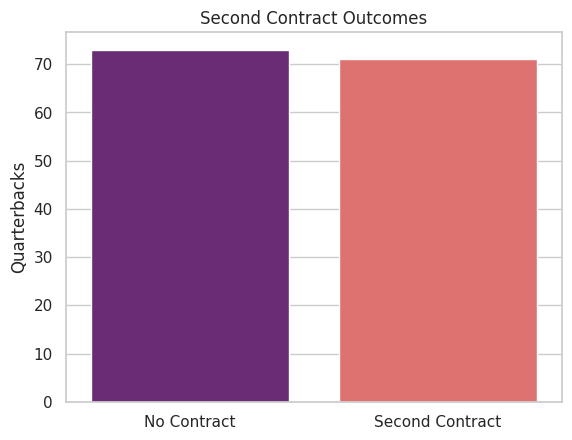

In [163]:
# Let's compare findings
# Bar plot!
sns.set(style = "whitegrid")
# Changing up the color palette, had to include hue and legend to avoid sns warning
sns.countplot(data = final_data, x = "Second_Contract", hue = "Second_Contract", palette="magma", legend = False)
plt.title("Second Contract Outcomes")
# Binary outcome
plt.xticks([0, 1], ["No Contract", "Second Contract"])
plt.xlabel("")
plt.ylabel("Quarterbacks")
plt.show()

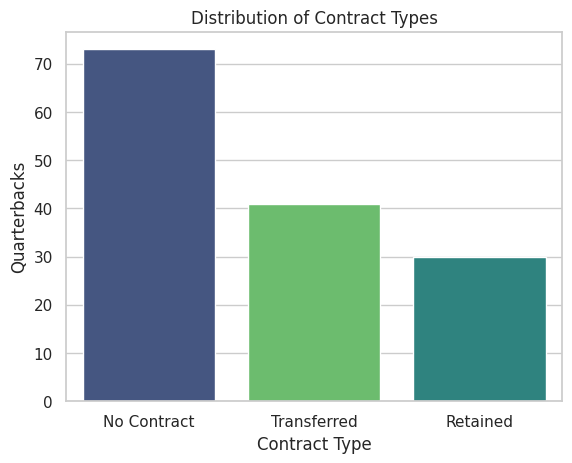

In [164]:
# Now, I will plot more specifics --> Transferred, Retained, No Contract
sns.countplot(data = final_data, x = "Contract_Type", hue = "Contract_Type", palette = "viridis", legend = False, order = ["No Contract", "Transferred", "Retained"])
plt.title("Distribution of Contract Types")
plt.xlabel("Contract Type")
plt.ylabel("Quarterbacks")
plt.show()

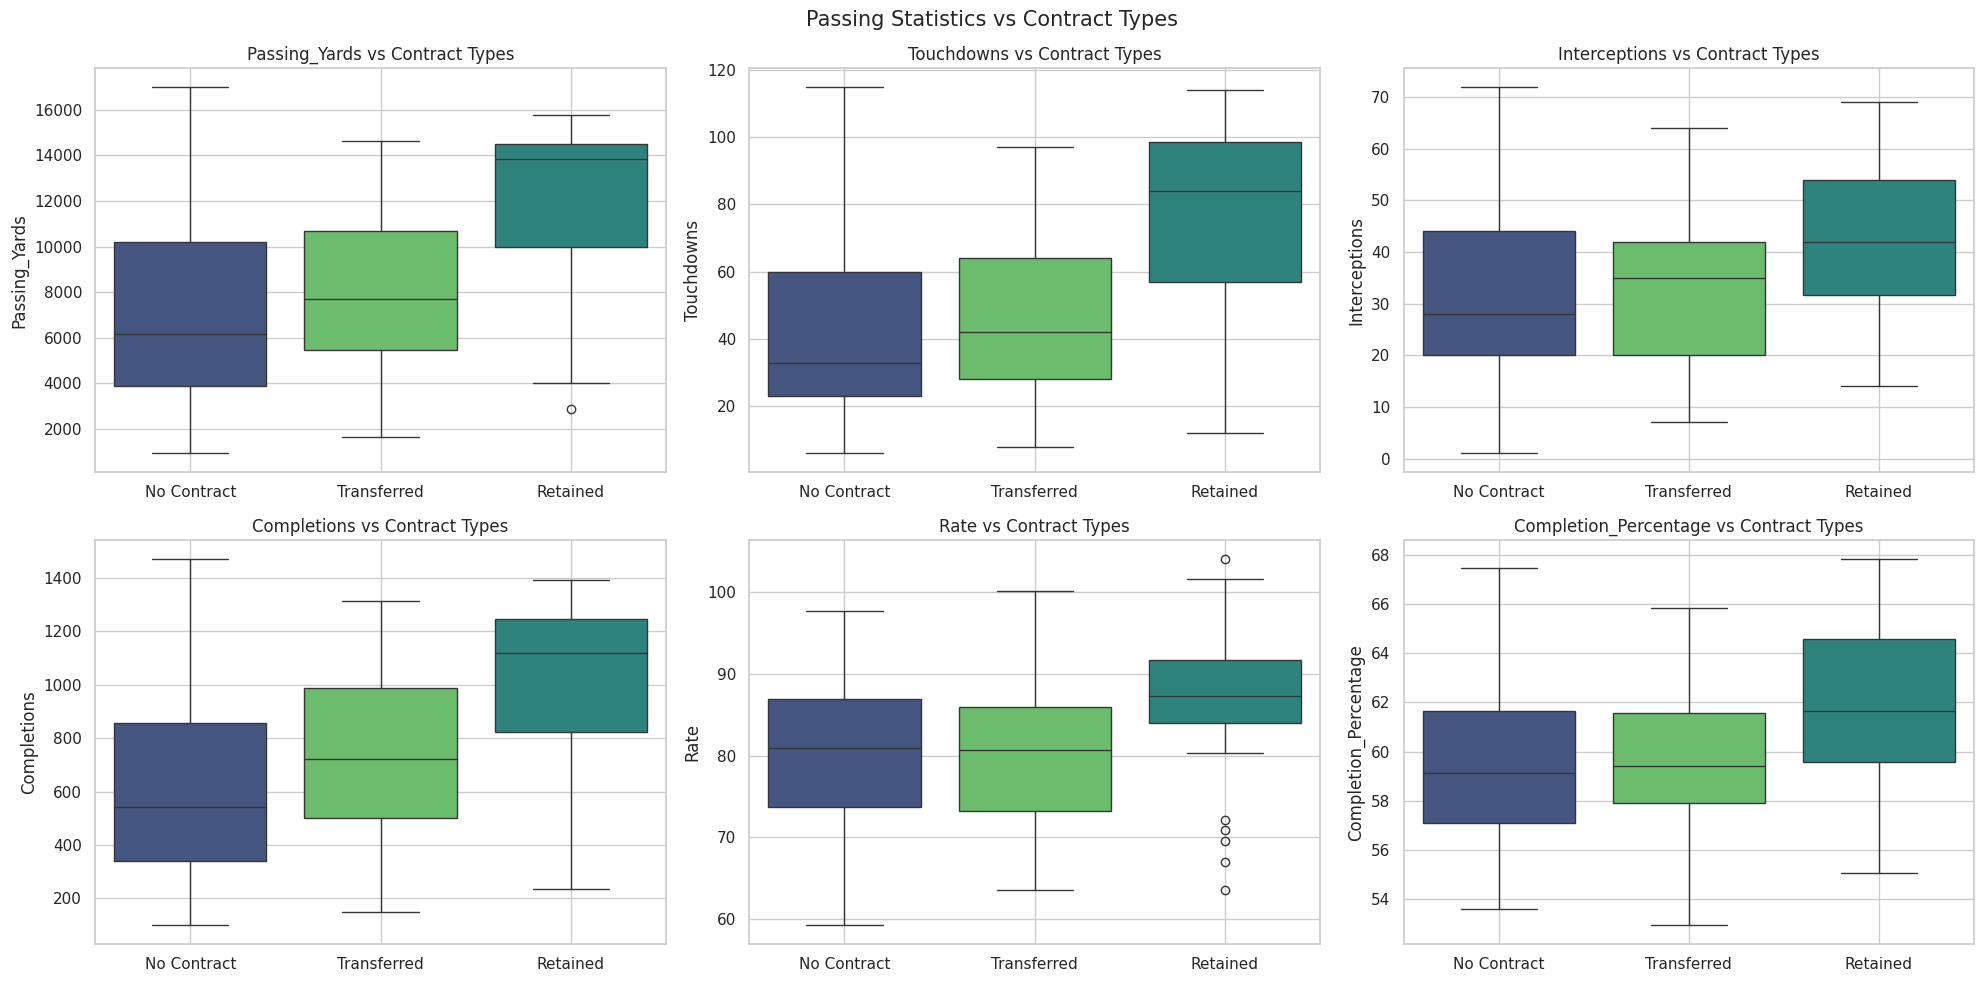

In [165]:
# Features by Contract Type!
def box_helper(ax, df, col):
  sns.boxplot(data = df, x = "Contract_Type", y = col, ax = ax, hue="Contract_Type", palette="viridis", legend = False, order = ["No Contract", "Transferred", "Retained"])
  ax.set_xlabel("")
  ax.set_ylabel(col)
  ax.set_title(f"{col} vs Contract Types")
  ax.grid(True)

cols = ["Passing_Yards", "Touchdowns", "Interceptions", "Completions", "Rate", "Completion_Percentage"]
# making it 2 x 3 plot -- took out attempts as it is not a good feature
fig, axes = plt.subplots(2, 3, figsize = (20, 10))
axes = axes.flatten()
# plotting each
for i, col in enumerate(cols):
  box_helper(axes[i], final_data, col)
plt.suptitle("Passing Statistics vs Contract Types", fontsize = 15)
plt.tight_layout()
plt.show()

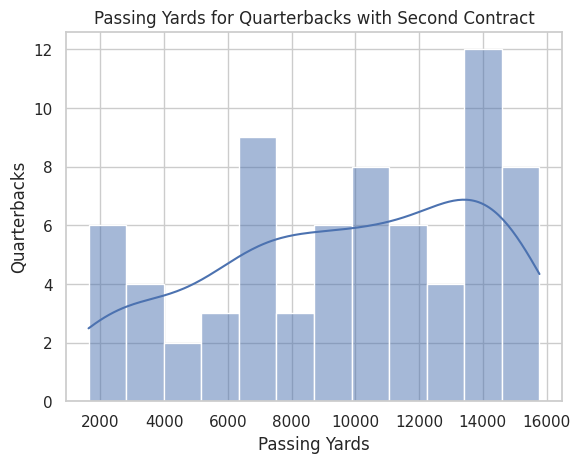

In [166]:
# Focusing on passing yards, lets do a bar chart for only second contract receiving players.
# I am expecting a bimodal distribution for backup and starter groups.

sc_qb = final_data[final_data["Second_Contract"] == 1]
sns.histplot(data = sc_qb, x = "Passing_Yards", bins = 12, kde = True)
plt.title("Passing Yards for Quarterbacks with Second Contract")
plt.xlabel("Passing Yards")
plt.ylabel("Quarterbacks")
plt.show()

In [167]:
# this is to see the per season stats!
contract_stat_mean = final_data.groupby("Second_Contract")[["Passing_Yards","Touchdowns","Interceptions","Attempts","Completions"]].mean()
season_avg = contract_stat_mean / 4
display(season_avg)

,Passing_Yards,Touchdowns,Interceptions,Attempts,Completions
Second_Contract,,,,,
0,1790.893836,10.613014,8.102740,261.438356,156.126712
1,2408.880282,14.757042,9.193662,344.169014,210.179577


In [168]:
# Model Training and Testing!!
X = final_data[["Touchdowns", "Interceptions", "Completions", "Passing_Yards", "Rate", "Completion_Percentage"]]
y = final_data["Second_Contract"]

# 80/20 split as mentioned in proposal
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42, stratify = y)
# stratify used in order to remove noise!

# need to scale for logistic and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

              precision    recall  f1-score   support

           0       0.57      0.53      0.55        15
           1       0.53      0.57      0.55        14

    accuracy                           0.55        29
   macro avg       0.55      0.55      0.55        29
weighted avg       0.55      0.55      0.55        29

Confusion Matrix: 
[[8 7]
 [6 8]]


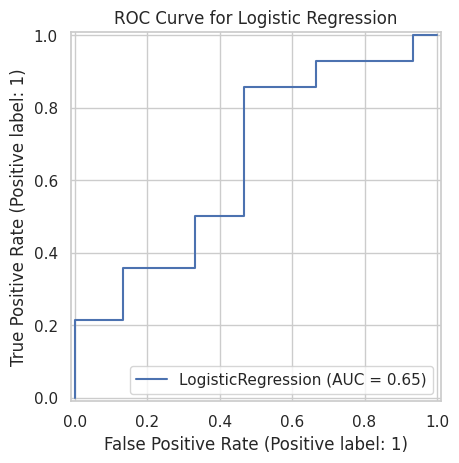

In [169]:
# Logistic Regression!
log_model = LogisticRegression(max_iter = 2000, class_weight='balanced')
log_model.fit(X_train_scaled, y_train)
log_pred = log_model.predict(X_test_scaled)
# for auc
# printing the evaluation metrics, confusion matrix and roc curve
print(classification_report(y_test, log_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, log_pred))
# RocCurveDisplay takes care of the calculations, dont need to do it manually
RocCurveDisplay.from_estimator(log_model, X_test_scaled, y_test)
plt.title("ROC Curve for Logistic Regression")
plt.show()

              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.67      0.71      0.69        14

    accuracy                           0.69        29
   macro avg       0.69      0.69      0.69        29
weighted avg       0.69      0.69      0.69        29

Confusion Matrix: 
[[10  5]
 [ 4 10]]


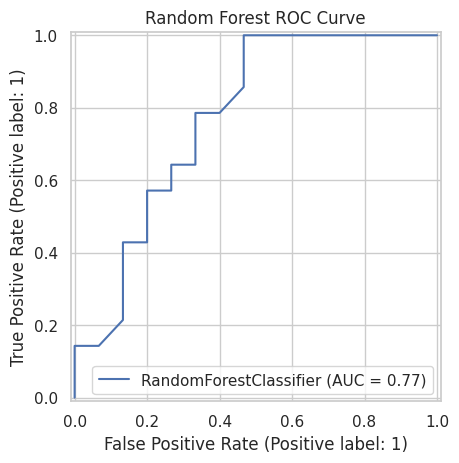

In [170]:
# Random Forest!
rfc = RandomForestClassifier(random_state = 42, class_weight='balanced')
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

# report, confusion matrix and the area under curve calculated!
print(classification_report(y_test, rfc_pred))
print("Confusion Matrix: ")
print(confusion_matrix(y_test, rfc_pred))

RocCurveDisplay.from_estimator(rfc, X_test, y_test)
plt.title("Random Forest ROC Curve")
plt.show()

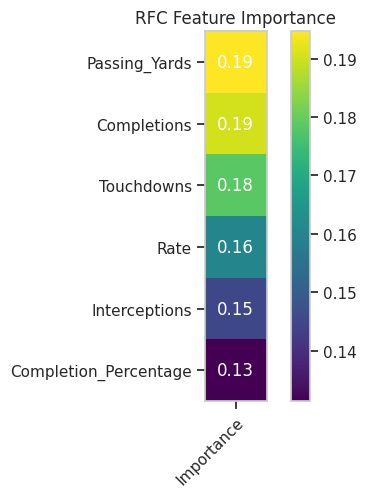

In [171]:
# to see which features are important!
importances = pd.Series(rfc.feature_importances_, index = X.columns)
order = importances.sort_values(ascending=False)
# let's make it pretty by making it a heatmap (like lecture code)
hm = heatmap(np.array(order).reshape(-1, 1), row_names=order.index, column_names=["Importance"])
plt.title("RFC Feature Importance")
plt.show()

              precision    recall  f1-score   support

           0       0.62      0.53      0.57        15
           1       0.56      0.64      0.60        14

    accuracy                           0.59        29
   macro avg       0.59      0.59      0.59        29
weighted avg       0.59      0.59      0.59        29

Confusion Matrix: 
[[8 7]
 [5 9]]


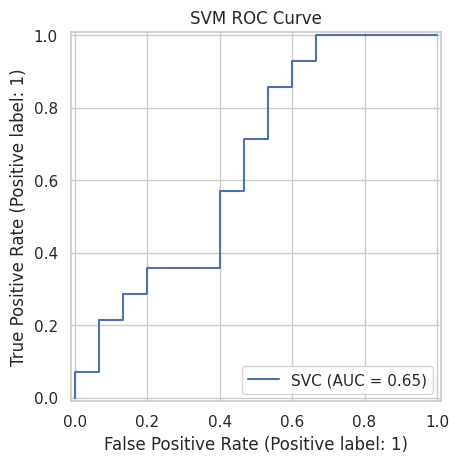

In [172]:
#SVM!
# need the probabilty as true for roc (learned from hw)
svm = SVC(probability = True, class_weight='balanced')
svm.fit(X_train_scaled, y_train)
svm_pred = svm.predict(X_test_scaled)
print(classification_report(y_test, svm_pred))
# svm_probability = svm.predict_proba(X_test_scaled)[:, 1]
print("Confusion Matrix: ")
print(confusion_matrix(y_test, svm_pred))
# dont need to calculate probability again
RocCurveDisplay.from_estimator(svm, X_test_scaled, y_test)
plt.title("SVM ROC Curve")
plt.show()

In [173]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_pred))
print("Random Forrest Accuracy:", accuracy_score(y_test, rfc_pred))
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))

Logistic Regression Accuracy: 0.5517241379310345
Random Forrest Accuracy: 0.6896551724137931
SVM Accuracy: 0.5862068965517241


In [174]:
# Similar to lecture code
log_p = Pipeline([("scaler", StandardScaler()), ("model", LogisticRegression(max_iter = 2000, class_weight = "balanced"))])
svm_p = Pipeline([("scaler", StandardScaler()), ("model", SVC(class_weight = "balanced", probability = True))])
rfc_p = RandomForestClassifier(random_state = 42, class_weight = "balanced")
# Cross validation like homework!
# K fold cross validation for all the metrics
fold = KFold(n_splits = 5, shuffle = True, random_state = 42)
metrics = ["accuracy", "precision", "recall", "f1"]
for m in metrics:
  # loop will do each metrics and display for analysis
  print("Metric:", m)
  log_cv = cross_val_score(log_p, X, y, cv = fold, scoring= m)
  print("Logistic Regression:", log_cv)
  svm_cv = cross_val_score(svm_p, X, y, cv = fold, scoring = m)
  print("SVM:", svm_cv)
  rfc_cv = cross_val_score(rfc_p, X, y, cv = fold, scoring = m)
  print("RFC:", rfc_cv)
  print('\n')

Metric: accuracy
Logistic Regression: [0.75862069 0.44827586 0.68965517 0.44827586 0.71428571]
SVM: [0.65517241 0.55172414 0.68965517 0.48275862 0.71428571]
RFC: [0.68965517 0.4137931  0.75862069 0.55172414 0.57142857]


Metric: precision
Logistic Regression: [0.72727273 0.375      0.875      0.5        0.75      ]
SVM: [0.57142857 0.46153846 0.75       0.52631579 0.72222222]
RFC: [0.6        0.35294118 0.83333333 0.58823529 0.625     ]


Metric: recall
Logistic Regression: [0.66666667 0.5        0.46666667 0.5        0.75      ]
SVM: [0.66666667 0.5        0.6        0.625      0.8125    ]
RFC: [0.75       0.5        0.66666667 0.625      0.625     ]


Metric: f1
Logistic Regression: [0.69565217 0.42857143 0.60869565 0.5        0.75      ]
SVM: [0.61538462 0.48       0.66666667 0.57142857 0.76470588]
RFC: [0.66666667 0.4137931  0.74074074 0.60606061 0.625     ]




In [175]:
# R2 -- focusing on contracts
second_contract_qbs = contract_info[contract_info["Signing_Team"].notna()][["Player", "Draft_Team", "Signing_Team", "Contract_Type"]]
second_contract_qbs

,Player,Draft_Team,Signing_Team,Contract_Type
0,A.J. McCarron,CIN,LV,Transferred
1,Aaron Rodgers,GB,GB,Retained
2,Alex Smith,SF,SF,Retained
3,Andrew Luck,IND,IND,Retained
4,Andy Dalton,CIN,CIN,Retained
...,...,...,...,...
138,Tommy Stevens,NO,NYG,Transferred
139,Trace McSorley,BAL,ARI,Transferred
141,Trevor Siemian,DEN,NYJ,Transferred
144,Tyrod Taylor,BAL,BUF,Transferred


In [176]:
# reusing my code from above
second_values = (data2[data2["Year_Signed"] > data2["Draft_Year"]].sort_values(["Player", "Year_Signed"]).groupby("Player").first().reset_index()[["Player", "Normalized_Contract_Value", "Normalized_Guaranteed_Value", "Year_Signed"]])
second_contract_qbs = second_contract_qbs.merge(second_values, on="Player", how="left")
# addinf Draft_Year to second_contract_qbs
draft_years = data2[["Player", "Draft_Year"]].drop_duplicates()
# merge again!
second_contract_qbs = second_contract_qbs.merge(draft_years, on="Player", how="left")
second_contract_qbs

,Player,Draft_Team,Signing_Team,Contract_Type,Normalized_Contract_Value,Normalized_Guaranteed_Value,Year_Signed,Draft_Year
0,A.J. McCarron,CIN,LV,Transferred,0.056433,0.033860,2018,2014
1,Aaron Rodgers,GB,GB,Retained,0.547586,0.172414,2008,2005
2,Alex Smith,SF,SF,Retained,0.052846,0.032520,2009,2005
3,Andrew Luck,IND,IND,Retained,0.791975,0.560314,2016,2012
4,Andy Dalton,CIN,CIN,Retained,0.721805,0.127820,2014,2011
...,...,...,...,...,...,...,...,...
118,Tommy Stevens,NO,NYG,Transferred,0.003616,0.000000,2021,2020
119,Trace McSorley,BAL,ARI,Transferred,0.009945,0.000000,2021,2019
120,Trevor Siemian,DEN,NYJ,Transferred,0.010627,0.005313,2019,2015
121,Tyrod Taylor,BAL,BUF,Transferred,0.023381,0.008026,2015,2011


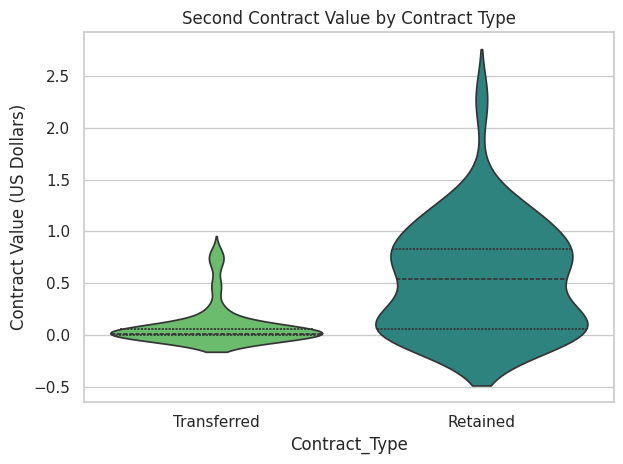

In [177]:
palette_match = sns.color_palette("viridis", 3)
# This is done so colors are consistent throughout retianed and transferred
color_picks = {"Transferred": palette_match[2], "Retained": palette_match[1]}
sns.violinplot(data = second_contract_qbs, x = "Contract_Type", y = "Normalized_Contract_Value", hue = "Contract_Type", palette = color_picks, legend = False, inner = "quartile")
plt.title("Second Contract Value by Contract Type")
plt.ylabel("Contract Value (US Dollars)")
plt.tight_layout()
plt.show()

In [178]:
# helper to define if contracts are best, good, average
def sd_helper2(z):
  if z < -.5:
    return "Below_Market"
  elif z > .5:
    return "Above_Market"
  else:
    return "Market_Average"

contract_qbs = second_contract_qbs.copy()
# divided up to eras in order to see the best in each!
contract_qbs["Era_Start"] = (contract_qbs["Year_Signed"] // 5) * 5
# to label the 5 year ranges
contract_qbs["Era"] = contract_qbs["Era_Start"].astype(str) + "-" + (contract_qbs["Era_Start"] + 5).astype(str)
# Deriving the values
era_stats = contract_qbs.groupby("Era")["Normalized_Contract_Value"].agg(["mean","std"])
era_stats = era_stats.rename(columns={"mean": "Era_Mean", "std": "Era_Std"})
contract_qbs = contract_qbs.merge(era_stats, on="Era", how="left")
# z value, similar to the features done above
contract_qbs["Contract_Z"] = ((contract_qbs["Normalized_Contract_Value"] - contract_qbs["Era_Mean"]) /contract_qbs["Era_Std"])
contract_qbs["Contract_Group"] = contract_qbs["Contract_Z"].apply(sd_helper2)
# lower threshold so made a new helper
contract_qbs[["Player", "Year_Signed", "Era","Normalized_Contract_Value", "Normalized_Guaranteed_Value", "Era_Mean", "Era_Std","Contract_Z", "Contract_Group"]]

,Player,Year_Signed,Era,Normalized_Contract_Value,Normalized_Guaranteed_Value,Era_Mean,Era_Std,Contract_Z,Contract_Group
0,A.J. McCarron,2018,2015-2020,0.056433,0.033860,0.147229,0.253803,-0.357741,Market_Average
1,Aaron Rodgers,2008,2005-2010,0.547586,0.172414,0.355619,0.355736,0.539634,Above_Market
2,Alex Smith,2009,2005-2010,0.052846,0.032520,0.355619,0.355736,-0.851116,Below_Market
3,Andrew Luck,2016,2015-2020,0.791975,0.560314,0.147229,0.253803,2.540345,Above_Market
4,Andy Dalton,2014,2010-2015,0.721805,0.127820,0.234853,0.336646,1.446480,Above_Market
...,...,...,...,...,...,...,...,...,...
118,Tommy Stevens,2021,2020-2025,0.003616,0.000000,0.323718,0.573243,-0.558406,Below_Market
119,Trace McSorley,2021,2020-2025,0.009945,0.000000,0.323718,0.573243,-0.547366,Below_Market
120,Trevor Siemian,2019,2015-2020,0.010627,0.005313,0.147229,0.253803,-0.538221,Below_Market
121,Tyrod Taylor,2015,2015-2020,0.023381,0.008026,0.147229,0.253803,-0.487970,Market_Average


In [179]:
above_market_qbs = contract_qbs[contract_qbs["Contract_Group"] == "Above_Market"]
# By doing this, I answer my second research question
above_market_qbs[["Player", "Normalized_Contract_Value", "Normalized_Guaranteed_Value", "Era", "Era_Mean", "Era_Std", "Contract_Z"]]

,Player,Normalized_Contract_Value,Normalized_Guaranteed_Value,Era,Era_Mean,Era_Std,Contract_Z
1,Aaron Rodgers,0.547586,0.172414,2005-2010,0.355619,0.355736,0.539634
3,Andrew Luck,0.791975,0.560314,2015-2020,0.147229,0.253803,2.540345
4,Andy Dalton,0.721805,0.127820,2010-2015,0.234853,0.336646,1.446480
8,Ben Roethlisberger,0.758504,0.286207,2005-2010,0.355619,0.355736,1.132540
14,Brock Osweiler,0.463708,0.238295,2015-2020,0.147229,0.253803,1.246951
16,Cam Newton,0.724456,0.418760,2015-2020,0.147229,0.253803,2.274313
18,Carson Palmer,1.134503,0.280702,2005-2010,0.355619,0.355736,2.189498
19,Carson Wentz,0.680128,0.573170,2015-2020,0.147229,0.253803,2.099657
26,Colin Kaepernick,0.857143,0.458647,2010-2015,0.234853,0.336646,1.848500
30,Daniel Jones,0.711744,0.462633,2020-2025,0.323718,0.573243,0.676895


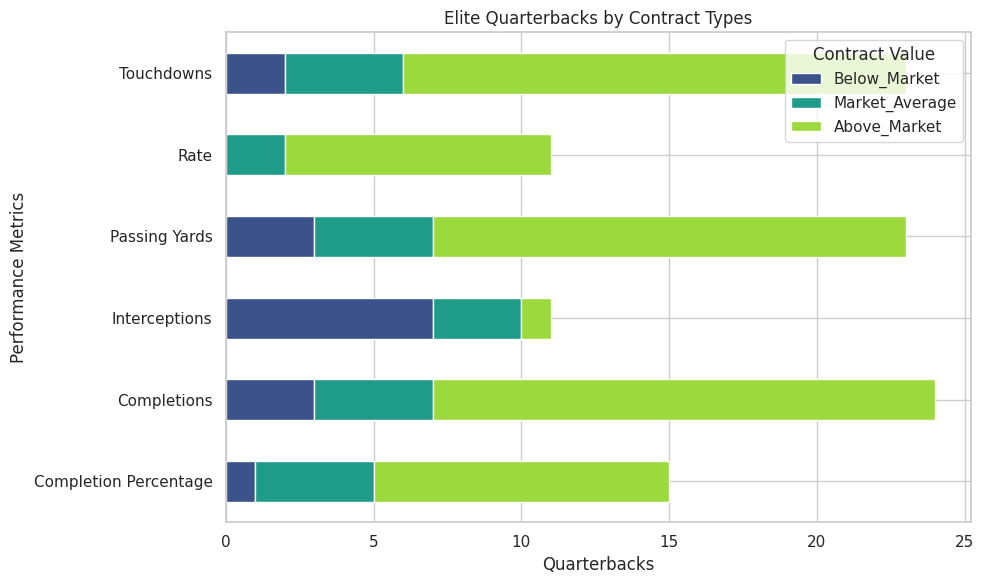

In [180]:
# to get the contract groups --> the reason there is a lot of merges is because of the difficulty of having two datas
master_df = final_data.merge(contract_qbs[["Player", "Contract_Group"]],on="Player", how="left")
arr = []
# I will portray these as my features!
best_features = {"Passing_Yards_Group": "Passing Yards", "Touchdown_Group": "Touchdowns", "Completion_Percentage_Group": "Completion Percentage","Rate_Group": "Rate", "Interceptions_Group" : "Interceptions", "Completion_Group" : "Completions"}

# going through them and only picking the elites
for x, y in best_features.items():
  e_qb = master_df[master_df[x] == "Elite"]
  # need to count for each bar
  nums = (e_qb["Contract_Group"].dropna().value_counts().reset_index())
  nums.columns = ["Contract_Group", "Count"]
  nums["Feature"] = y
  arr.append(nums)
result = pd.concat(arr)
# changing the format
stacked_graph = (result.pivot(index = "Feature", columns = "Contract_Group", values = "Count").reindex(columns = ["Below_Market", "Market_Average", "Above_Market"]))
#making sure it is the same colors throughout
viridis = plt.get_cmap("viridis")
# not exact numbers, very similar!
colors = [viridis(0.25), viridis(0.55), viridis(0.85)]

# plotting!
stacked_graph.plot(kind = "barh", stacked = True, figsize = (10, 6), color = colors)
plt.title("Elite Quarterbacks by Contract Types")
plt.xlabel("Quarterbacks")
plt.ylabel("Performance Metrics")
plt.legend(title = "Contract Value")
plt.tight_layout()
plt.show()

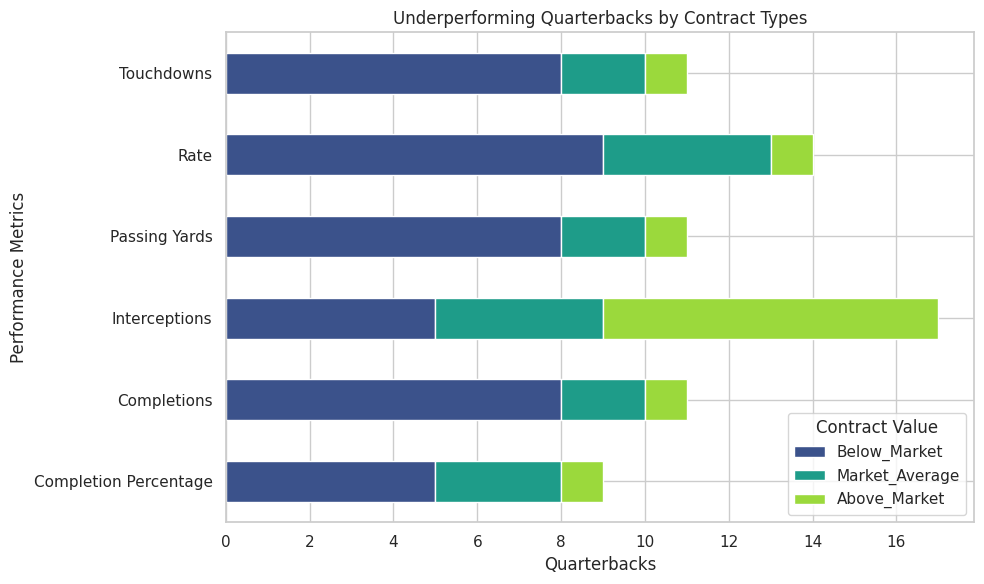

In [181]:
# Now, let's do underperforming in order to show that performance stats play a crucial role in contracts
master_df = final_data.merge(contract_qbs[["Player", "Contract_Group"]],on="Player", how="left")
arr = []
best_features = {"Passing_Yards_Group": "Passing Yards", "Touchdown_Group": "Touchdowns", "Completion_Percentage_Group": "Completion Percentage","Rate_Group": "Rate", "Interceptions_Group" : "Interceptions", "Completion_Group" : "Completions"}
# same code as above
for x, y in best_features.items():
  # only difference is underperforming this time!
  under = master_df[master_df[x] == "Underperforming"]
  nums = (under["Contract_Group"].dropna().value_counts().reset_index())
  nums.columns = ["Contract_Group", "Count"]
  nums["Feature"] = y
  arr.append(nums)
result = pd.concat(arr)
# changing the format --> need to have right order
stacked_graph = (result.pivot(index = "Feature", columns = "Contract_Group", values = "Count").reindex(columns=["Below_Market", "Market_Average", "Above_Market"]))
# making sure it is the same colors
viridis = plt.get_cmap("viridis")
colors = [viridis(0.25), viridis(0.55), viridis(0.85)]
#plotting:
stacked_graph.plot(kind = "barh", stacked = True, figsize = (10, 6), color =colors)
plt.title("Underperforming Quarterbacks by Contract Types")
plt.xlabel("Quarterbacks")
plt.ylabel("Performance Metrics")
plt.legend(title="Contract Value")
plt.tight_layout()
plt.show()